<a href="https://colab.research.google.com/github/Mahnoor-14/STock_APPLE_TimeSeriesANalysis/blob/main/TSAF_Forecasting_AAPL.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 📈 Time Series Analysis & Forecasting

Using stock data from Yahoo Finance to compare classical (ARIMA) vs deep learning (LSTM) forecasting.

In [7]:
# Installing required packages
!pip install yfinance --quiet
import yfinance as yf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.arima.model import ARIMA
from sklearn.metrics import mean_squared_error, mean_absolute_error
from math import sqrt
import seaborn as sns
import warnings
warnings.filterwarnings("ignore")



In [11]:

# Loading data
df = yf.download("AAPL", start="2018-01-01", end="2024-12-31")
df = df[["Close"]].dropna()
df.head()

[*********************100%***********************]  1 of 1 completed


Price,Close
Ticker,AAPL
Date,
2018-01-02,40.426826
2018-01-03,40.419781
2018-01-04,40.607529
2018-01-05,41.069866
2018-01-08,40.917320


##Time Series Analysis

ADF Statistic: 0.08300197719143605
p-value: 0.9648812142634616


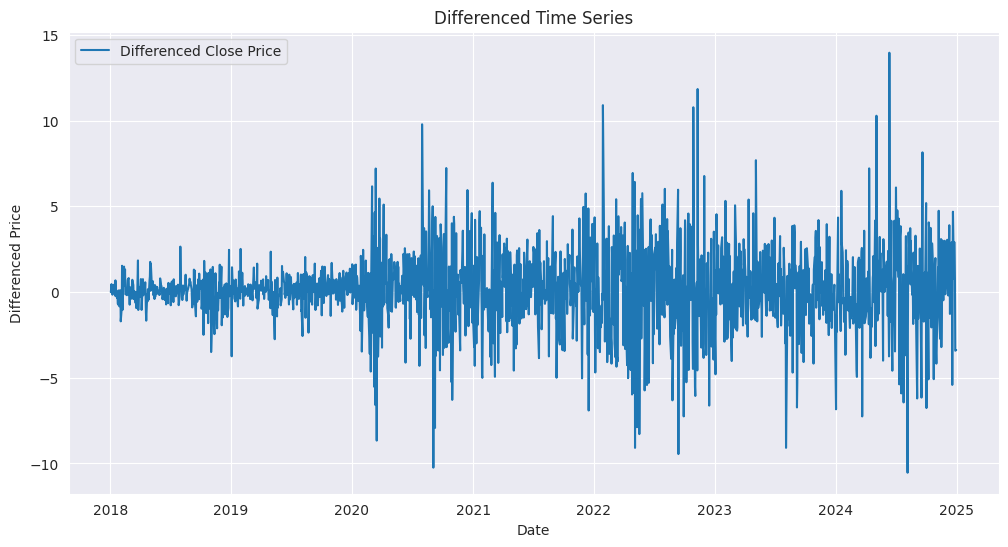

In [12]:
# Augmented Dickey-Fuller test for stationarity
result = adfuller(df['Close'])
print("ADF Statistic:", result[0])
print("p-value:", result[1])

# Apply first differencing if needed
df['Close_diff'] = df['Close'].diff()
df.dropna(inplace=True)

# Plot differenced series
plt.figure(figsize=(12, 6))
plt.plot(df['Close_diff'], label='Differenced Close Price')
plt.title("Differenced Time Series")
plt.xlabel("Date")
plt.ylabel("Differenced Price")
plt.legend()
plt.grid(True)
plt.show()

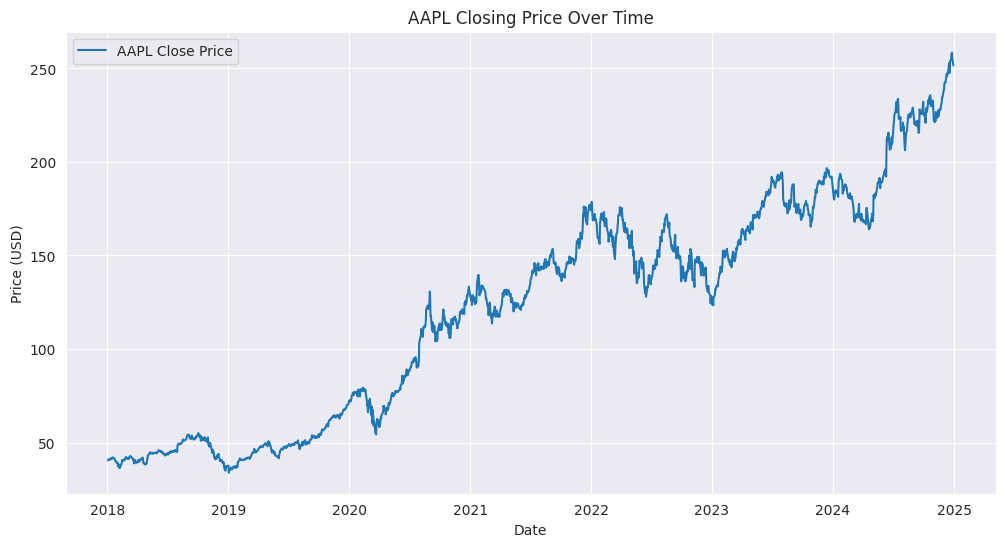

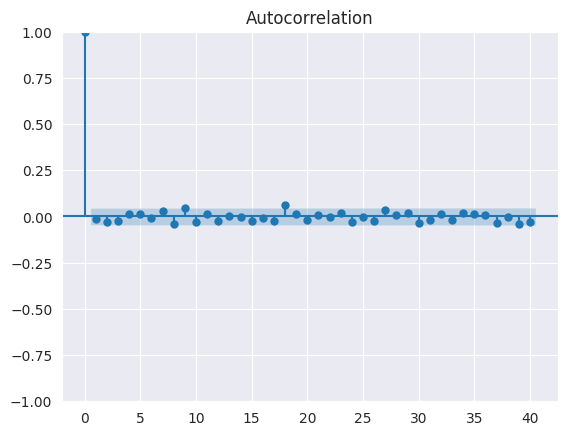

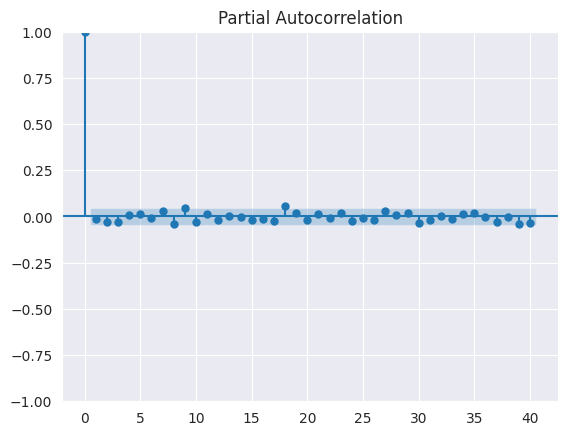

In [13]:

# Plotting Close price

plt.figure(figsize=(12, 6))
plt.plot(df['Close'], label='AAPL Close Price')
plt.title("AAPL Closing Price Over Time")
plt.xlabel("Date")
plt.ylabel("Price (USD)")
plt.legend()
plt.grid(True)
plt.show()

# ACF and PACF
plot_acf(df['Close_diff'], lags=40)
plt.show()

plot_pacf(df['Close_diff'], lags=40)
plt.show()

##ARIMA

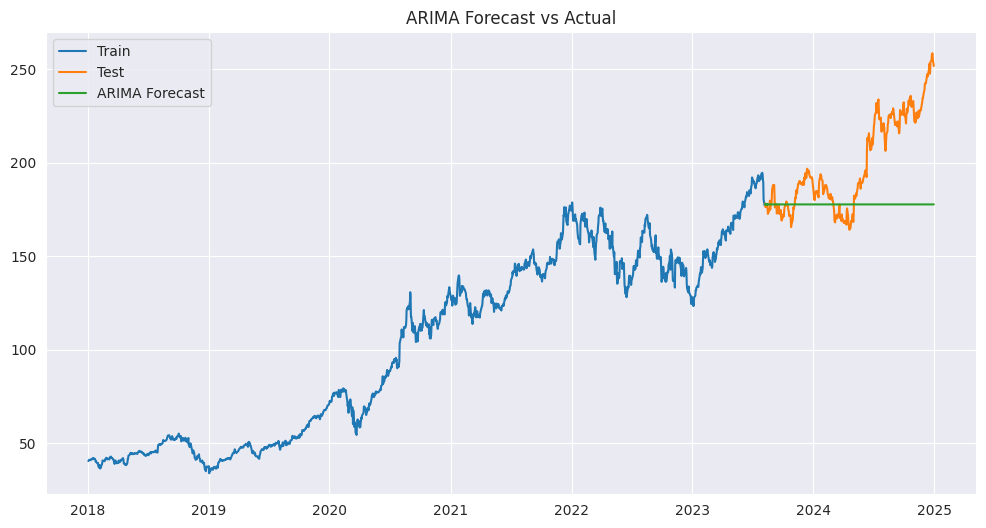

ARIMA MAE: 24.24, RMSE: 32.64


In [15]:
# Train-test split
train_size = int(len(df) * 0.8)
train, test = df.iloc[:train_size], df.iloc[train_size:]

# Fitting ARIMA
model = ARIMA(train['Close'], order=(5,1,1))  # p,d,q chosen from PACF/ADF
model_fit = model.fit()
forecast = model_fit.forecast(steps=len(test))

# Plotting ARIMA forecast
plt.figure(figsize=(12,6))
plt.plot(train.index, train['Close'], label='Train')
plt.plot(test.index, test['Close'], label='Test')
plt.plot(test.index, forecast, label='ARIMA Forecast')
plt.title("ARIMA Forecast vs Actual")
plt.legend()
plt.grid(True)
plt.show()

# Evaluating
arima_mae = mean_absolute_error(test['Close'], forecast)
arima_rmse = sqrt(mean_squared_error(test['Close'], forecast))
print(f"ARIMA MAE: {arima_mae:.2f}, RMSE: {arima_rmse:.2f}")

##  LSTM Deep Learning Model

11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step


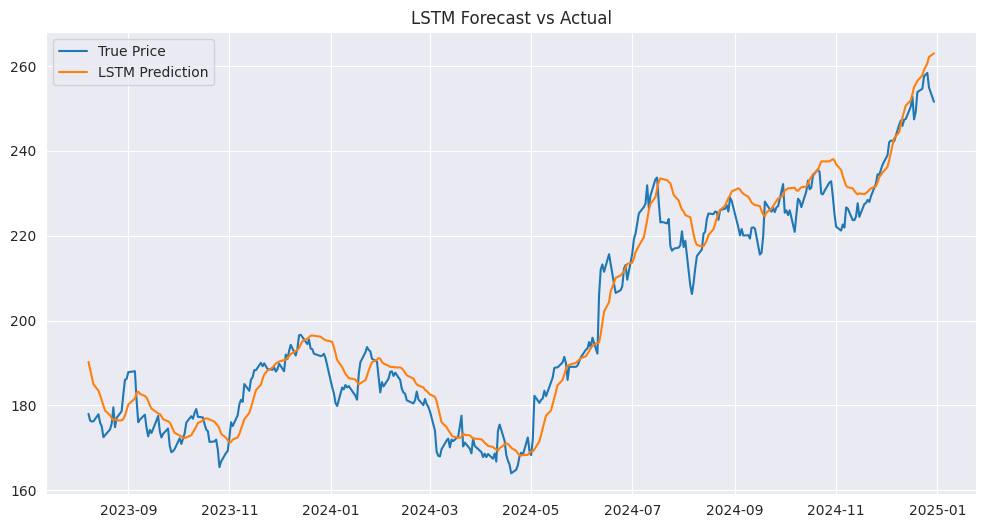

LSTM MAE: 4.50, RMSE: 5.66


In [16]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
from sklearn.preprocessing import MinMaxScaler

# Prepare data for LSTM
data = df[['Close']]
scaler = MinMaxScaler()
scaled_data = scaler.fit_transform(data)

def create_sequences(data, window):
    X, y = [], []
    for i in range(window, len(data)):
        X.append(data[i-window:i])
        y.append(data[i])
    return np.array(X), np.array(y)

window_size = 60
X, y = create_sequences(scaled_data, window_size)

# Train/test split
X_train, X_test = X[:train_size-window_size], X[train_size-window_size:]
y_train, y_test = y[:train_size-window_size], y[train_size-window_size:]

# Build LSTM
model = Sequential()
model.add(LSTM(50, activation='relu', return_sequences=False, input_shape=(X_train.shape[1], 1)))
model.add(Dense(1))
model.compile(optimizer='adam', loss='mse')

# Train
model.fit(X_train, y_train, epochs=10, batch_size=32, verbose=0)

# Predict
predicted = model.predict(X_test)
predicted = scaler.inverse_transform(predicted)
true = scaler.inverse_transform(y_test)

# Evaluate
lstm_mae = mean_absolute_error(true, predicted)
lstm_rmse = sqrt(mean_squared_error(true, predicted))

# Plot LSTM
plt.figure(figsize=(12, 6))
plt.plot(df.index[train_size:], true, label='True Price')
plt.plot(df.index[train_size:], predicted, label='LSTM Prediction')
plt.title("LSTM Forecast vs Actual")
plt.legend()
plt.grid(True)
plt.show()

print(f"LSTM MAE: {lstm_mae:.2f}, RMSE: {lstm_rmse:.2f}")

Interpretation


- LSTM performed significantly better than ARIMA in both error metrics.
- ARIMA assumes linearity and stationarity which limits its ability to capture non-linear trends.
- LSTM adapts to complex, dynamic financial patterns due to its memory-based architecture.
